# 201102 Inspect taxa

In [1]:
import json
from pathlib import Path
from collections import Counter

In [2]:
from zipfile import ZipFile
from gzip import GzipFile

In [3]:
import networkx as nx
from IPython.display import Image
from pygraphviz import AGraph

## File paths

In [4]:
infiles = dict(
    v1_archive='/home/jared/projects/midas/data/v1/archives/refseq_curated_1.1_beta_200525.midas-archive.gz',
    taxa=Path('../../data/intermediate/201031-database-v1.1-software-version-migration/201102-download-taxa/'),
)

In [5]:
tmpdir = Path('tmp')

## Load data

### v1.1 archive

In [ ]:
archive_zip = ZipFile(GzipFile(infiles['v1_archive']))
archive_zip.read('info').decode()

### Taxonomy

In [6]:
with open(infiles['taxa'] / 'taxa.json') as f:
    taxon_data = json.load(f)
    
# Convert to dict indexed by ID
taxon_data = {tdata['taxid']: tdata for tdata in taxon_data}

In [7]:
with open(infiles['taxa'] / 'aka_taxids.json') as f:
    aka_taxids = json.load(f)

In [8]:
with open(tmpdir / 'genome_true_taxids.json') as f:
    genome_taxids = json.load(f)

## Func defs

In [9]:
def resolve_alias(tid):
    return aka_taxids.get(tid, tid)

In [10]:
def gettaxon(tid):
    """Get taxon by ID, resolving alias IDs."""
    return taxon_data[resolve_alias(tid)]

In [11]:
def getparent(taxon):
    """Get taxon's parent, handling aliases of parent id."""
    if isinstance(taxon, int):
        taxon = taxon_data[taxon]
        
    try:
        return gettaxon(taxon['parent_taxid'])
    except KeyError:
        return None

In [12]:
def find_ancestor(taxon, accept, incself=False):
    """Find first ancestor of taxon for which accept() returns True."""
    if not incself:
        taxon = getparent(taxon)
        
    while taxon is not None and not accept(taxon):
        taxon = getparent(taxon)
        
    return taxon

In [13]:
def drawgraph(g, prog=None, format='png'):
    if isinstance(g, nx.Graph):
        g = nx.nx_agraph.to_agraph(g)
    if not isinstance(g, AGraph):
        raise TypeError('Expected networkx.Graph or pygraphviz.AGraph')
        
    if prog is None:
        prog = 'dot' if g.directed else 'neato'
    
    return Image(g.draw(prog=prog, format=format))

## Root taxa

In [14]:
root_taxa = [tdata for tdata in taxon_data.values() if getparent(tdata) is None]
root_taxa

[{'taxid': 1,
  'parent_taxid': 0,
  'scientific_name': 'root',
  'rank': 'no rank',
  'division': 'Unassigned',
  'create_date': '1995-02-27T09:24:00',
  'update_date': '2015-07-10T14:03:18',
  'pub_date': '1992-05-26T01:00:00',
  'aka_taxids': []}]

## Taxon ranks

### Rank counts

In [15]:
rank_counts = Counter(tdata['rank'] for tdata in taxon_data.values())
rank_counts

Counter({'species': 1475,
         'strain': 19373,
         'no rank': 471,
         'subspecies': 193,
         'biotype': 2,
         'serogroup': 13,
         'isolate': 10,
         'serotype': 88,
         'forma specialis': 5,
         'genus': 463,
         'species group': 40,
         'species subgroup': 11,
         'family': 169,
         'subgenus': 1,
         'order': 89,
         'subfamily': 1,
         'tribe': 2,
         'class': 36,
         'suborder': 2,
         'clade': 8,
         'phylum': 19,
         'superkingdom': 1,
         'subphylum': 1,
         'subclass': 1})

In [16]:
genome_rank_counts = Counter(taxon_data[tid]['rank'] for tid in genome_taxids)
genome_rank_counts

Counter({'species': 854,
         'strain': 19354,
         'no rank': 277,
         'subspecies': 103,
         'biotype': 2,
         'serogroup': 3,
         'isolate': 10,
         'serotype': 9,
         'forma specialis': 3})

In [ ]:
sorted(tdata['scientific_name'] for tdata in taxon_data.values() if tdata['rank'] == 'no rank')

In [ ]:
sorted(tdata['scientific_name'] for tdata in taxon_data.values() if tdata['rank'] == 'clade')

### Rank relationships

In [17]:
ignore_ranks = ['no rank', 'clade']

In [19]:
rank_rels = Counter()

for tdata in taxon_data.values():
    if tdata['rank'] in ignore_ranks:
        continue

    parent = find_ancestor(tdata, lambda t: t['rank'] not in ignore_ranks)
    if parent is None:
        continue
    
    rank_rels[(parent['rank'], tdata['rank'])] += 1

In [20]:
genome_rank_counts2 = Counter(
    find_ancestor(gettaxon(tid), lambda tdata: tdata['rank'] not in ignore_ranks, incself=True)['rank']
    for tid in genome_taxids
)
genome_rank_counts2

Counter({'species': 933,
         'strain': 19457,
         'subspecies': 177,
         'serogroup': 16,
         'biotype': 3,
         'isolate': 10,
         'serotype': 16,
         'forma specialis': 3})

In [21]:
rank_graph = nx.DiGraph()

for rank, count in rank_counts.items():
    if rank not in ignore_ranks:
        genome_count = genome_rank_counts2[rank]
        rank_graph.add_node(rank, count=count, genome_count=genome_count, label='%s (%d, %d)' % (rank, count, genome_count))
        
for (rank1, rank2), count in rank_rels.items():
    rank_graph.add_edge(rank1, rank2, count=count, label=str(count))

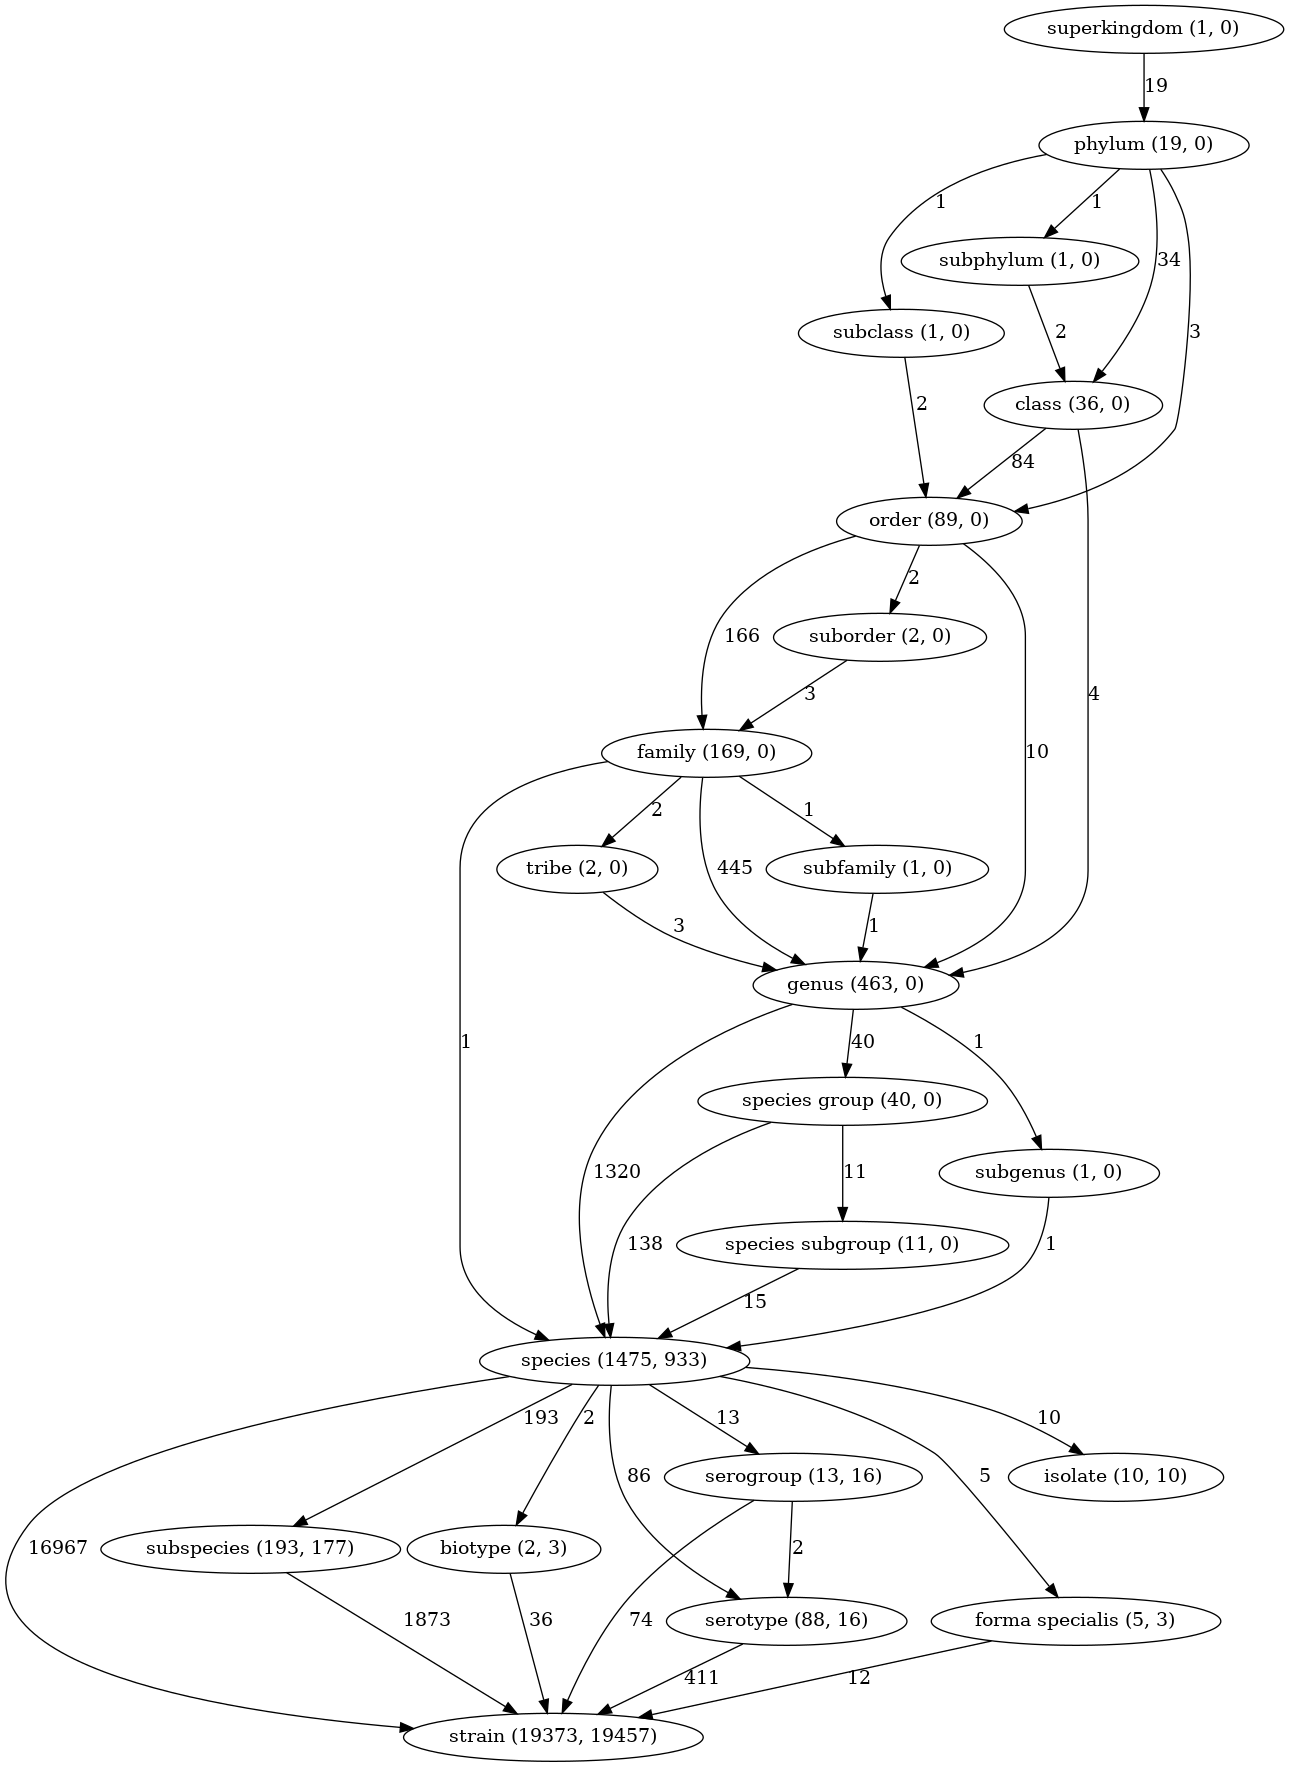

In [23]:
drawgraph(rank_graph)